# cuDatashader GPU FDEB Edge Bundling

This algorithm takes a graph (nodes and egdes) as input and produces a new graph by applying FDEB Edge Bundling on it. The produced graph is displayable thanks to Datashader/cuDatashader functions.

### General functionning of the algorithm (for more information https://ieeexplore.ieee.org/document/6385238)

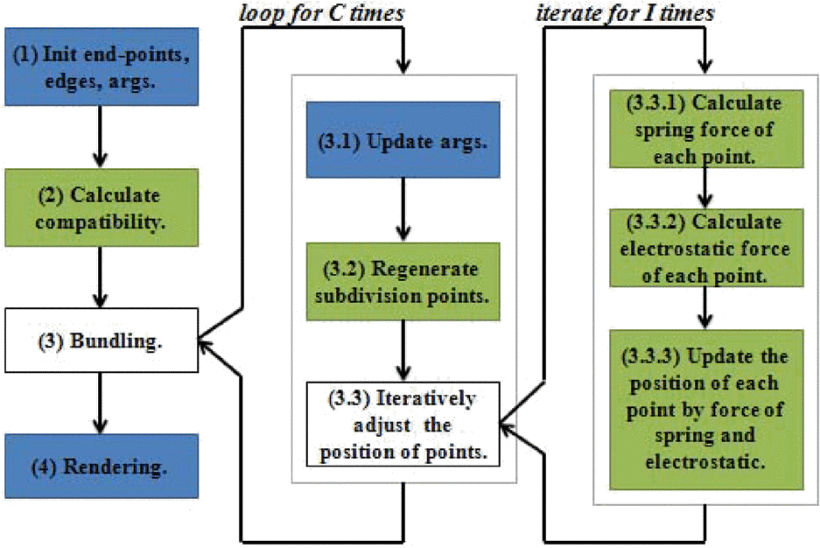

In [12]:
from IPython.display import Image
Image(filename='data/FDEB_edge_bundling.gif')

### Computation of pairwise edge compatibility (for more information http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.212.7989&rep=rep1&type=pdf)

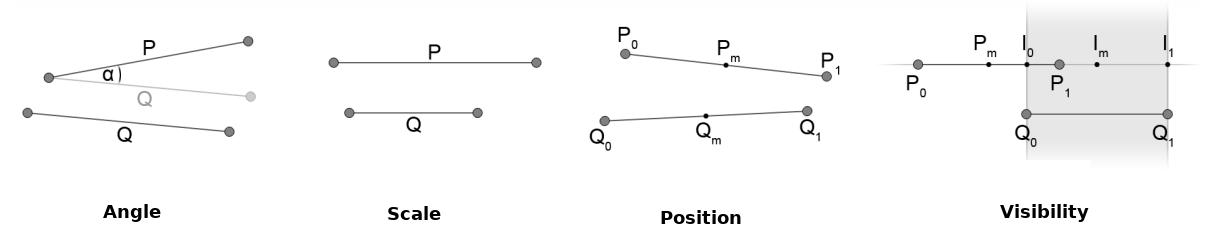

In [14]:
Image(filename='data/compatibility.png')

### Computation of Spring and Electostatic forces (for more information https://ieeexplore.ieee.org/document/6385238)

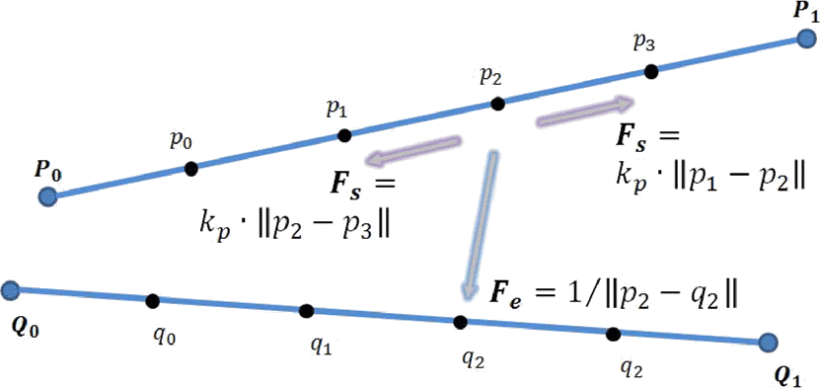

In [15]:
Image(filename='data/forces.gif')

### Demonstration of GPU FDEB Edge Bundling on small graphs

In [3]:
import math
import numpy as np
import pandas as pd

import cudatashader as ds
import cudatashader.transfer_functions as tf
from cudatashader.bundling import fdeb_bundle, connect_edges

import networkx as nx

import cudf

import matplotlib.pyplot as plt
import time

np.set_printoptions(threshold=np.inf)

In [4]:
def nodesplot(nodes, canvas=None, cat=None): # Plot nodes
    canvas = ds.Canvas(plot_height=400, plot_width=400) if canvas is None else canvas
    agg = canvas.points(nodes, 'x','y')
    return tf.spread(tf.shade(agg, cmap=['white', 'red'], how='linear'), px=5, shape='circle', how='saturate')

def edgesplot(edges, canvas=None): # Plot edges
    canvas = ds.Canvas(plot_height=400, plot_width=400) if canvas is None else canvas
    return tf.spread(tf.shade(canvas.line(edges, 'x','y'), how='linear'), px=1, shape='square', how='over')

def graphplot(nodes, edges, canvas=None, cat=None): # Plot graph (nodes + edges)
    if canvas is None:
        xr = nodes.x.min() - 0.1, nodes.x.max() + 0.1
        yr = nodes.y.min() - 0.1, nodes.y.max() + 0.1
        canvas = ds.Canvas(plot_height=400, plot_width=400, x_range=xr, y_range=yr)

    ep = edgesplot(edges, canvas) # Plot nodes
    np = nodesplot(nodes, canvas, cat) # Plot edges
    return tf.stack(ep, np, how="over") # Stack two images for final render

def nx_layout(graph): # Produce small graphs
    layout = nx.circular_layout(graph)
    data = [[node]+layout[node].tolist() for node in graph.nodes]

    nodes = pd.DataFrame(data, columns=['id', 'x', 'y'])
    nodes.set_index('id', inplace=True)

    edges = pd.DataFrame(list(graph.edges), columns=['source', 'target'])
    return nodes, edges

def nx_plot_without_bundling(graph): # Plot graph without edge bundling
    nodes, edges = nx_layout(graph) # Produce small graph
    # Convert to cuDF DataFrames
    nodes = cudf.DataFrame.from_pandas(nodes)
    edges = cudf.DataFrame.from_pandas(edges)
    direct = connect_edges(nodes, edges) # Simply connect edges (instead of edge bundling)
    return graphplot(nodes, direct)

def nx_plot_with_bundling(graph): # Plot graph with edge bundling
    nodes, edges = nx_layout(graph) # Produce small graph
    # Convert to cuDF DataFrames
    nodes = cudf.DataFrame.from_pandas(nodes)
    edges = cudf.DataFrame.from_pandas(edges)
    direct = fdeb_bundle(nodes, edges) # GPU FDEB Edge Bundling
    return graphplot(nodes, direct) # Plot graph

def display_comparison(graph):
    t0 = time.time()
    img1 = nx_plot_without_bundling(graph) # First image (on the left) without edge bundling
    print("Edge Bundling rendered in {} ms".format(round((time.time() - t0) * 1000)))
    img2 = nx_plot_with_bundling(graph) # Second image (on the right) with edge bundling
    f = plt.figure(dpi=200)
    f.add_subplot(1,2, 1)
    plt.imshow(img1.data)
    f.add_subplot(1,2, 2)
    plt.imshow(img2.data)
    plt.show(block=True)

Edge Bundling rendered in 686 ms


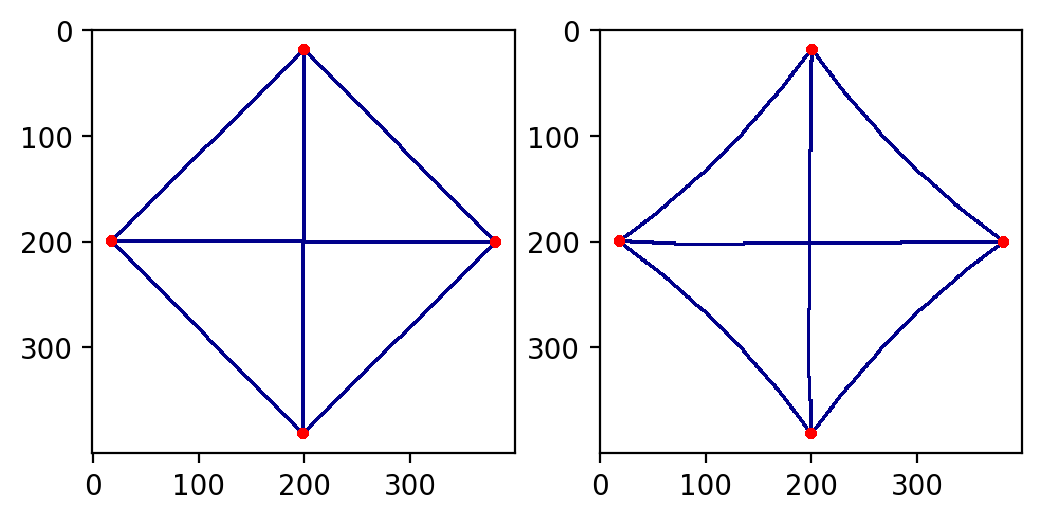

In [5]:
display_comparison(nx.tetrahedral_graph())

Edge Bundling rendered in 122 ms


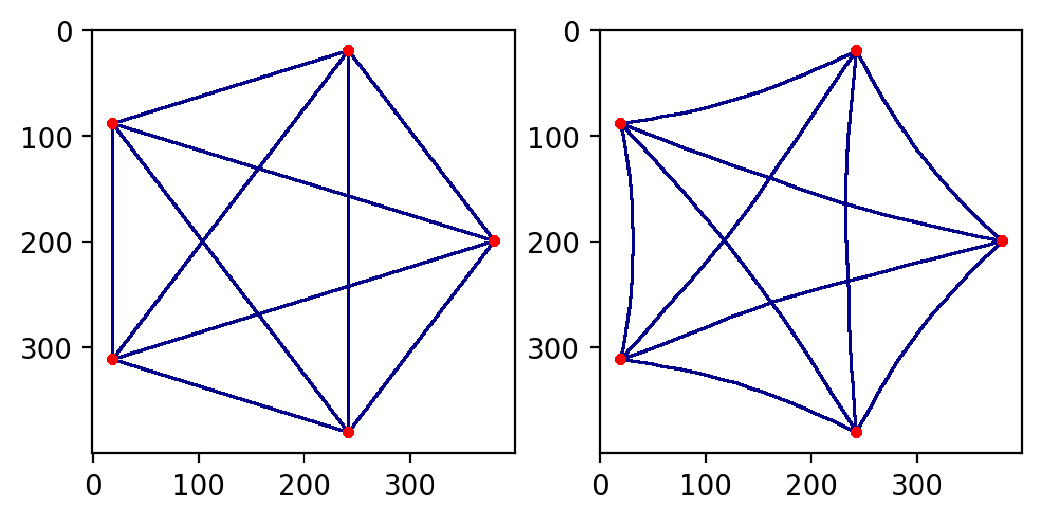

In [6]:
display_comparison(nx.complete_graph(5))

Edge Bundling rendered in 136 ms


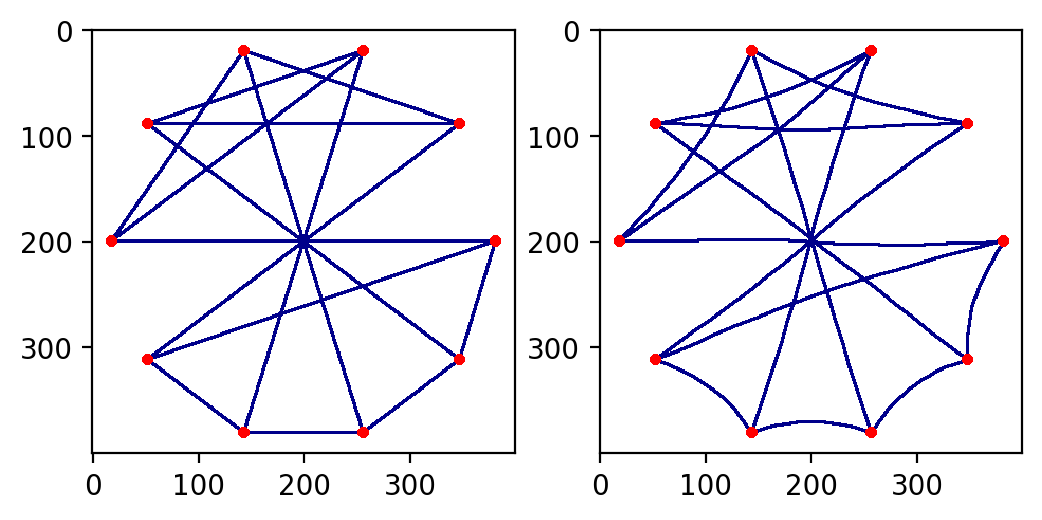

In [7]:
display_comparison(nx.petersen_graph())

Edge Bundling rendered in 133 ms


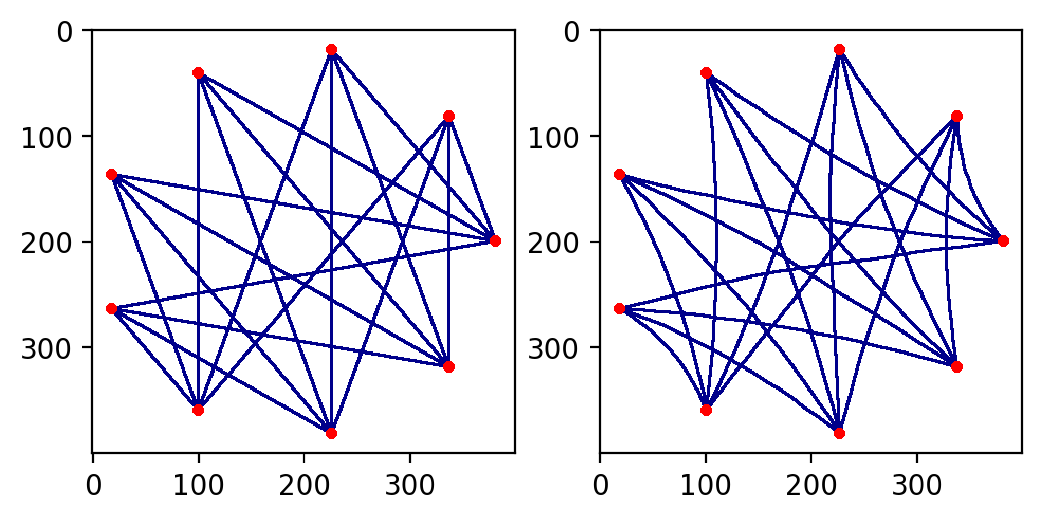

In [8]:
display_comparison(nx.complete_bipartite_graph(4, 5))

Edge Bundling rendered in 124 ms


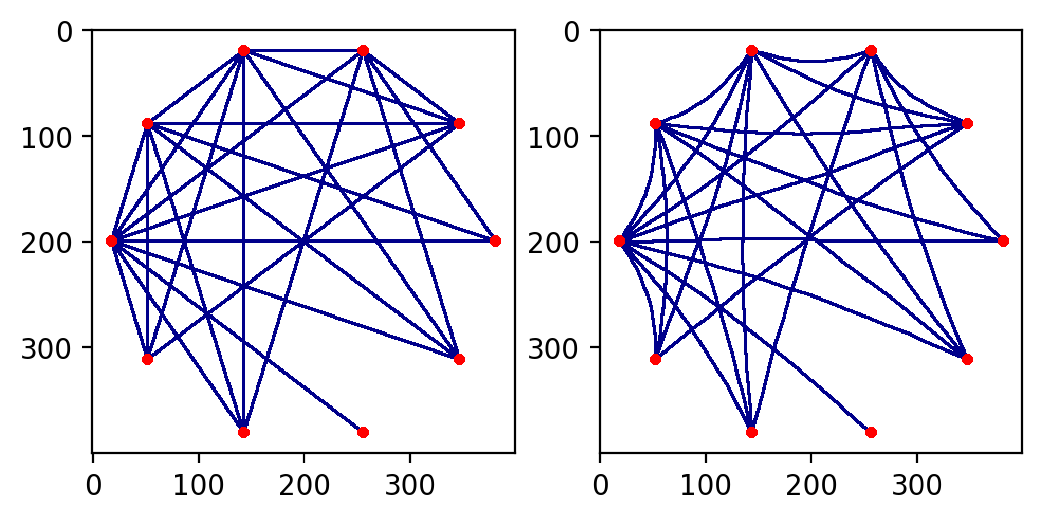

In [9]:
display_comparison(nx.barabasi_albert_graph(10, 5))

Edge Bundling rendered in 219 ms


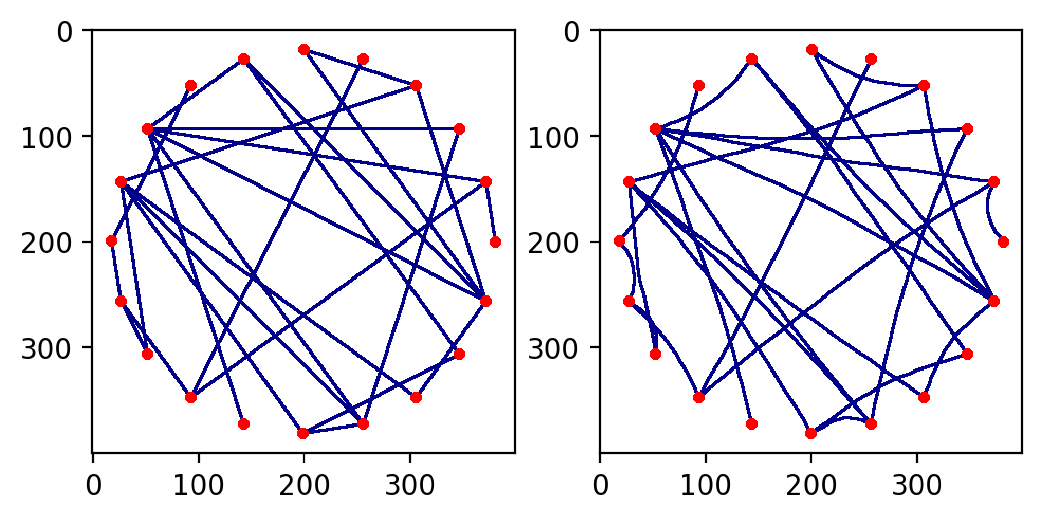

In [10]:
display_comparison(nx.erdos_renyi_graph(20, 0.15))

Edge Bundling rendered in 152 ms


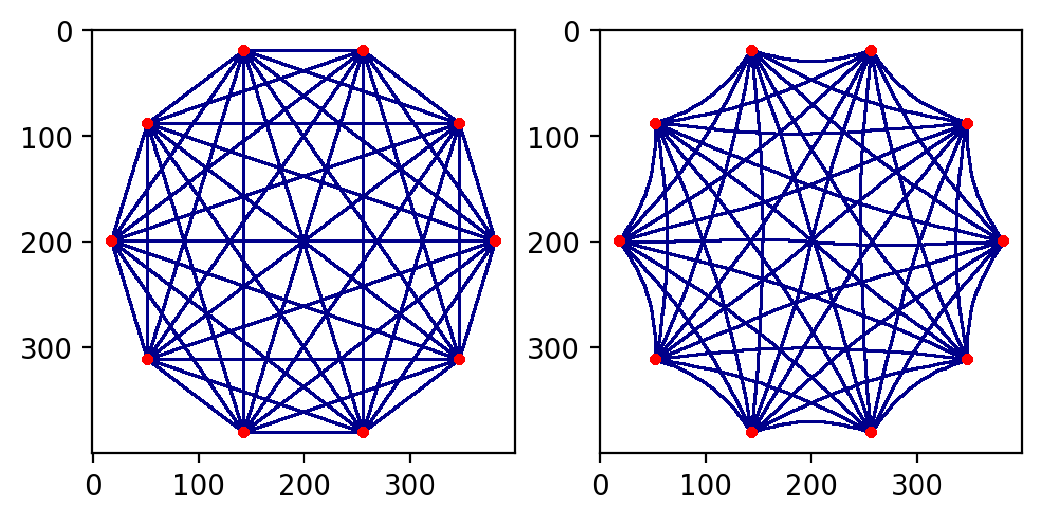

In [11]:
display_comparison(nx.complete_graph(10))